In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/workspace/assignments/supervised_lieaning/k_nearest_neighbors")

import numpy as np
from dataset.cifar10_loader import CIFAR10Loader
from assignment import ModelExperimentManager
from assignment.experiment import TrainSizeExperiment, FeatureCompressExperiment, NumClassExperiment
SEED = 6
np.random.seed(SEED)

2025-05-23 03:10:14.917933: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-23 03:10:14.922421: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-23 03:10:14.931932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747969814.947464   34649 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747969814.952909   34649 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747969814.968327   34649 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## CIFAR10データのダウンロードと分割

In [26]:
data_loader = CIFAR10Loader(SEED)

CFAR10データセットはTrain用が50000枚、Test用が10000枚の画像データからなるセットです。ダウンロードできました。
Train用の2割をEvalation用にします。つまり (Train, Evaluation, Test) は (40000, 10000, 10000) の枚数からなります。


## 実験設定
1. 学習データ量の実験パターンは 学習データセット全体を 1 としたときの比率で指定する。設定は `TRAIN_RATIOS` で与える。
2. 特徴量の実験パターンは Notebook最下部の補足欄に示す主成分分析の結果を踏まえて定めた。設定は `FEATURE_DIMS` で与える。
3. クラス数の実験パターンの設定は `CLASS_GROUPS` で与える。

In [ ]:
TRAIN_RATIOS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
CLASS_GROUPS = [
   ['cat', 'dog'],  # 2クラス
   ['cat', 'dog', 'horse'],   # 3クラス
   ['cat', 'dog', 'horse', 'frog'],   # 4クラス
   ['cat', 'dog', 'horse', 'frog', 'deer'], # 5クラス
   ['cat', 'dog', 'horse', 'frog', 'deer', "bird"], # 6クラス
   ['cat', 'dog', 'horse', 'frog', 'deer', "bird", 'airplane'], # 7クラス
   ['cat', 'dog', 'horse', 'frog', 'deer', "bird", 'airplane', 'automobile'], # 8クラス
   ['cat', 'dog', 'horse', 'frog', 'deer', "bird", 'airplane', 'automobile', 'ship'], # 9クラス
]
FEATURE_DIMS = [7, 10, 20, 50, 80, 125, 200]


これらの設定は、 後ほど`Experiment`系オブジェクトに与える。`XxxxExperiment`オブジェクトは、実験設定をデータに適用する役割を担う。
- 課題 1 のデータを扱う `TrainSizeExperiment` クラス
- 課題 2 のデータを扱う `NumClassExperiment` クラス
- 課題 3 のデータを扱う `FeatureCompressExperiment` クラス

各 `XxxxExperiment`オブジェクト は、実験を指揮する主体である `ModelExperimentManager` オブジェクトの `run_experiment()` 関数に与えられ、その内部で学習データ生成役として働く。

In [27]:
# 交差検証の設定
KNN_PARAMS = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# 課題1
どのクラスを用いるかで学習難易度が変わると感じたので、「犬と猫の分類」と「猫と自動車の分類」の2パターンを実施した。

犬と猫の分類

Original Trainset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
Original Evalset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
Original Testset-1.0 -> ラベル['cat', 'dog']が付与された画像データを抽出します。
訓練データ 800個(10%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 1600個(20%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 2400個(30%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 3200個(40%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 4000個(50%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 4800個(60%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 5600個(70%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 6400個(80%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 7200個(90%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 7920個(99%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits


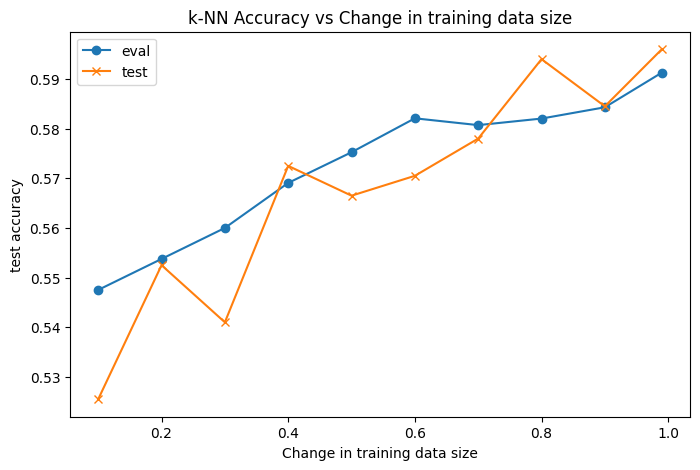

In [31]:
# データは犬と猫の2クラスに絞ったものを用いる
train_dset, eval_dset, _ = data_loader.get_datasubsets(['cat', 'dog'], verbose=True)

# 検証用データを `ModelExperimentManager` に与えて初期化
exp_mgr = ModelExperimentManager(eval_dset)

# 実験設定をデータに反映する `TrainSizeExperiment` オブジェクトを生成
tr_exp = TrainSizeExperiment(train_dset, TRAIN_RATIOS, SEED)

# 実験の実行
tracker_tr = exp_mgr.run_experiment(tr_exp, KNN_PARAMS)

猫と自動車の分類

Original Trainset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
Original Evalset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
Original Testset-1.0 -> ラベル['cat', 'automobile']が付与された画像データを抽出します。
訓練データ 800個(10%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 1600個(20%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 2400個(30%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 3200個(40%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 4000個(50%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 4800個(60%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 5600個(70%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 6400個(80%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 7200個(90%) で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
訓練データ 7920個(99%) で学習
Fitting 3 folds for each of 10 candidate

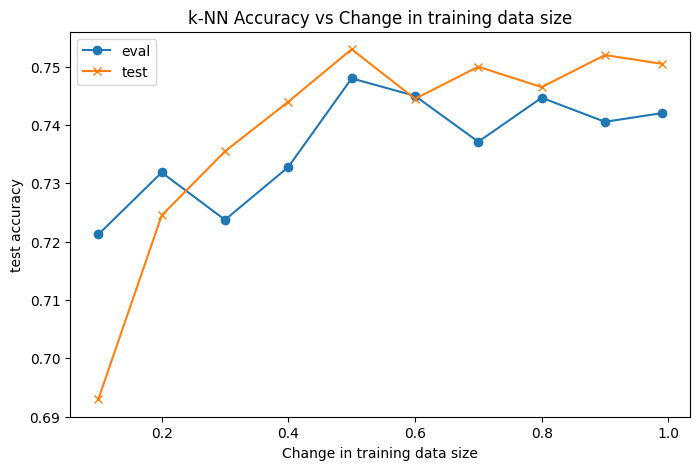

In [32]:
# データは猫と自動車の2クラスに絞ったものを用いる
train_dset, eval_dset, _ = data_loader.get_datasubsets(['cat', 'automobile'], verbose=True)

# 検証用データを `ModelExperimentManager` に与えて初期化
exp_mgr = ModelExperimentManager(eval_dset)

# 実験設定をデータに反映する `TrainSizeExperiment` オブジェクトを生成
tr_exp = TrainSizeExperiment(train_dset, TRAIN_RATIOS, SEED)

# 実験の実行
tracker_tr = exp_mgr.run_experiment(tr_exp, KNN_PARAMS)

## 考察
データ数を増加させると正解率が改善する傾向がある。

正解率は、①犬と猫の分類 が50%台と低めで、②猫と自動車の分類 は70%台と高めという結果であった。これは①の方が特徴量が類似しており難しそうだという直観と一致する。  
①については、学習データを増やすにつれて正解率が向上していることから、さらにデータを追加することでモデルの性能を向上させることができそうである。  
これに対して、②はデータ数を増やしても正解率が横這いになっており、これ以上データ数を増加させても正解率の改善は見込めないかもしれない。このタスクにおけるknn法の限界を感じる。

### 課題 2 の実施

クラス数 2 個で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
クラス数 3 個で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
クラス数 4 個で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
クラス数 5 個で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
クラス数 6 個で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
クラス数 7 個で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
クラス数 8 個で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits
クラス数 9 個で学習
Fitting 3 folds for each of 10 candidates, totalling 30 fits


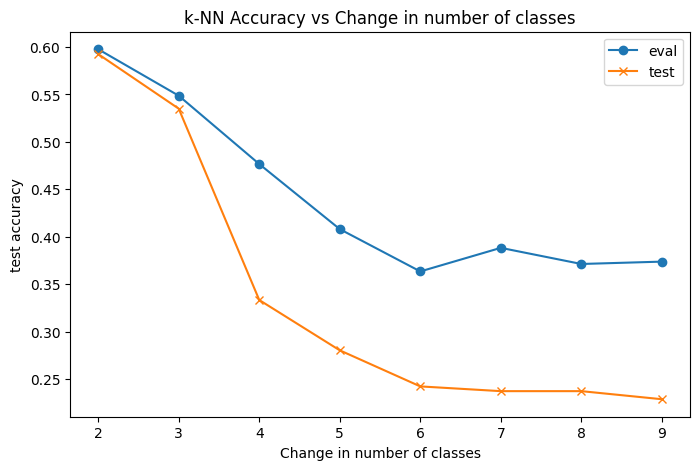

In [21]:
tracker_cls = exp_mgr.run_experiment(nclass_exp, KNN_PARAMS)

### 課題 3 の実施
データは犬と猫の2クラスに絞ったものを用いる。

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


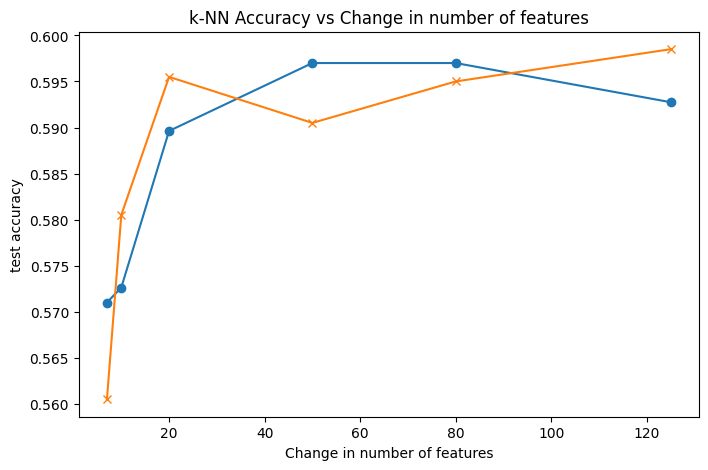

In [7]:
tracker_fcomp = exp_mgr.run_experiment(fcomp_exp, KNN_PARAMS)

次元削減の設定を説明力を見て決める

# 補足
### 主成分の説明力の調査

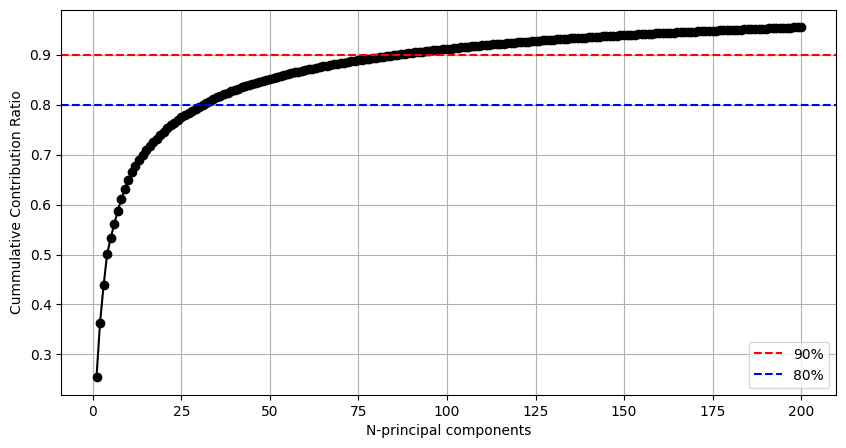

In [25]:
from assignment.pca_image_compressor import PCAImageCompressor

model = PCAImageCompressor(200)
x_reduced = model.fit_transform(train_dset)
model.plot_cummulative_contribution_ratio()